### Import Dependencies

In [119]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from skimage.color import rgb2gray
import cv2
from PIL import Image
from torchsummary import summary

In [93]:
torch.cuda.is_available()

False

### Import Datasets and Get Classes

In [94]:
for dirpath, dirnames, filenames in os.walk("data"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

letter_class = len(os.listdir("data/train"))

dataset_dir = pathlib.Path("data/train")
class_names = np.array(sorted([item.name for item in dataset_dir.glob("*")]))
print(class_names)

There are 13 directories and 3 images in data
There are 0 directories and 1 images in data\bright
There are 0 directories and 1 images in data\coba
There are 0 directories and 14 images in data\cropped_char
There are 0 directories and 47 images in data\input
There are 0 directories and 70 images in data\input fix
There are 0 directories and 3990 images in data\input2
There are 0 directories and 2 images in data\letter
There are 0 directories and 1 images in data\output
There are 0 directories and 0 images in data\predicted
There are 36 directories and 0 images in data\test
There are 0 directories and 157 images in data\test\0
There are 0 directories and 159 images in data\test\1
There are 0 directories and 155 images in data\test\2
There are 0 directories and 156 images in data\test\3
There are 0 directories and 155 images in data\test\4
There are 0 directories and 156 images in data\test\5
There are 0 directories and 156 images in data\test\6
There are 0 directories and 155 images in 

### Data Preprocessing

##### Call the dataset

In [95]:
resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
])

image_dataset = datasets.ImageFolder(root='data/train/',transform=resize_transform)

##### Show image example in each class

In [96]:
# Define the classes of your dataset
classes = image_dataset.classes

# Create a figure with subplots for each class
fig, axes = plt.subplots(6, 6, figsize=(12, 12))

# Loop through each class and plot the first image
for i, cls in enumerate(classes):
    # Get the indices of the images for this class
    indices = [j for j, (x, y) in enumerate(image_dataset) if y == i]
    # Get the first image for this class
    img = image_dataset[indices[0]][0]
    img = img.resize((256, 256))
    # Plot the image on the corresponding subplot
    axes.flat[i].imshow(img)
    axes.flat[i].set_title(cls)

plt.show()

##### Create image preprocessing

In [107]:
class OtsuTransform:
    def __call__(self, image):
        # Convert the PIL Image to a NumPy array
        image_array = np.array(image)
        
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        
        # Convert the grayscale image to the desired format (8-bit or 16-bit)
        if gray_image.dtype != np.uint8:
            gray_image = (gray_image * 255).astype(np.uint8)
        
        # Apply Otsu's thresholding
        _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Convert the binary image back to a PIL Image
        binary_image = Image.fromarray(binary_image)
        
        # Return the binary image
        return binary_image

In [108]:
# Example usage
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    OtsuTransform(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

##### Show image transformation

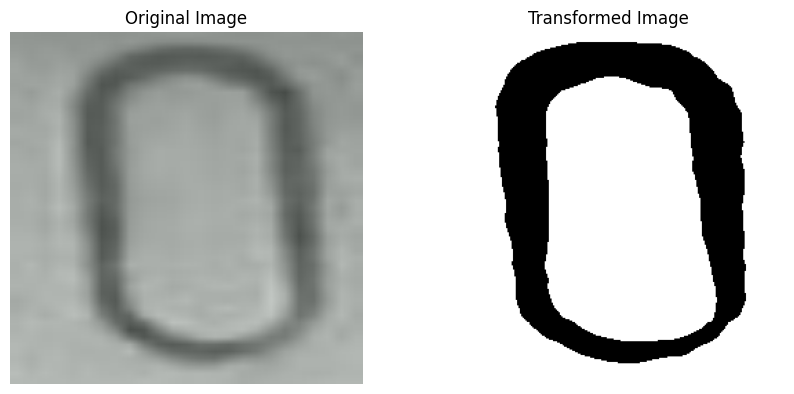

In [117]:
example_image, _ = image_dataset[0]
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(example_image)
# ax[0].set_title('Before transform')
# transformed_image = transform(example_image)
# transformed_image = transformed_image.squeeze().numpy()
# ax[1].imshow(transformed_image.permute(1, 2, 0))
# ax[1].set_title('After transform')
# plt.show()

transformed_image = transform(example_image)



fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Original Image
axs[0].imshow(example_image)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Transformed Image
transformed_image = transformed_image.squeeze().numpy()   # Squeeze the additional dimension
axs[1].imshow(transformed_image, cmap='gray')
axs[1].set_title('Transformed Image')
axs[1].axis('off')

plt.show()

### ResNet50 Model Building

##### Hyperparameter Setup

In [110]:
num_classes = 36
batch_size = 64
num_epochs = 64
learning_rate = 0.0001

##### Apply preprocessing to transform the dataset

In [111]:
train_set = datasets.ImageFolder(root='data/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set = datasets.ImageFolder(root='data/val/', transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = datasets.ImageFolder(root='data/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

##### Load pre-trained ResNet50 model

In [112]:
resnet50 = models.resnet50(pretrained=True)

# Modify the input channel of the first convolutional layer
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Salma\Coba\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [113]:
# Freeze all layers in the pre-trained model
for param in resnet50.parameters():
    param.requires_grad = False

In [114]:
# Replace the last fully connected layer with a new one
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

In [125]:
summary(resnet50, (1, 256, 256), 64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 64, 128, 128]           3,136
       BatchNorm2d-2         [64, 64, 128, 128]             128
              ReLU-3         [64, 64, 128, 128]               0
         MaxPool2d-4           [64, 64, 64, 64]               0
            Conv2d-5           [64, 64, 64, 64]           4,096
       BatchNorm2d-6           [64, 64, 64, 64]             128
              ReLU-7           [64, 64, 64, 64]               0
            Conv2d-8           [64, 64, 64, 64]          36,864
       BatchNorm2d-9           [64, 64, 64, 64]             128
             ReLU-10           [64, 64, 64, 64]               0
           Conv2d-11          [64, 256, 64, 64]          16,384
      BatchNorm2d-12          [64, 256, 64, 64]             512
           Conv2d-13          [64, 256, 64, 64]          16,384
      BatchNorm2d-14          [64, 256,

d:\Salma\Coba\venv\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


##### Define loss function and optimizer

In [115]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Train and Validate Model

##### Train the model

In [116]:
# Train the model
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Iterate over the validation dataset in batches
train_predictions = np.array([])
train_ground_truths = np.array([])

for epoch in range(num_epochs):
    # Training
    resnet50.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.cpu()
        labels = labels.cpu()
        
        optimizer.zero_grad()
        
        outputs = resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    train_losses.append(train_loss/train_total)
    train_accs.append(train_correct/train_total)
    
    # Validation
    resnet50.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = resnet50(images)
            loss = criterion(outputs, labels)

            train_predictions = np.concatenate((train_predictions, predicted.cpu().numpy()))
            train_ground_truths = np.concatenate((train_ground_truths, labels.cpu().numpy()))

            
            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        # remove the extra predictions
        if len(train_predictions) > len(train_ground_truths):
            train_predictions = train_predictions[:len(train_ground_truths)]
        elif len(train_predictions) < len(train_ground_truths):
            train_ground_truths = train_ground_truths[:len(train_predictions)]

        print(len(train_predictions), len(train_ground_truths))

    # Convert predictions and true labels to numpy arrays
    train_predictions = np.array(train_predictions)
    train_ground_truths = np.array(train_ground_truths)
    
    val_losses.append(val_loss/val_total)
    val_accs.append(val_correct/val_total)
    
    # Print epoch statistics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_losses[-1], train_accs[-1], val_losses[-1], val_accs[-1]))

KeyboardInterrupt: 

In [ ]:
average_val = 'macro'

accuracy = accuracy_score(train_ground_truths, train_predictions)
precision = precision_score(train_ground_truths, train_predictions, average=average_val)
recall = recall_score(train_ground_truths, train_predictions, average=average_val)
f1 = f1_score(train_ground_truths, train_predictions, average=average_val)

print(f"Accuracy: {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall: {round(recall * 100, 2)}%")
print(f"F1 Score: {round(f1 * 100, 2)}%")

Accuracy: 90.39%
Precision: 87.99%
Recall: 87.92%
F1 Score: 87.94%


##### Plot losses and accuracy

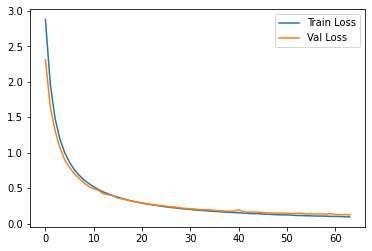

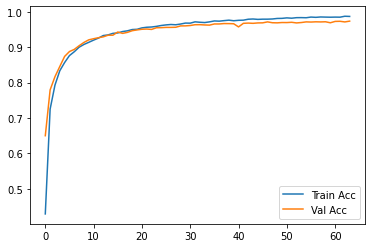

In [ ]:
#Losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

#Accuracy
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.show()

##### Calculate the confusion matrix

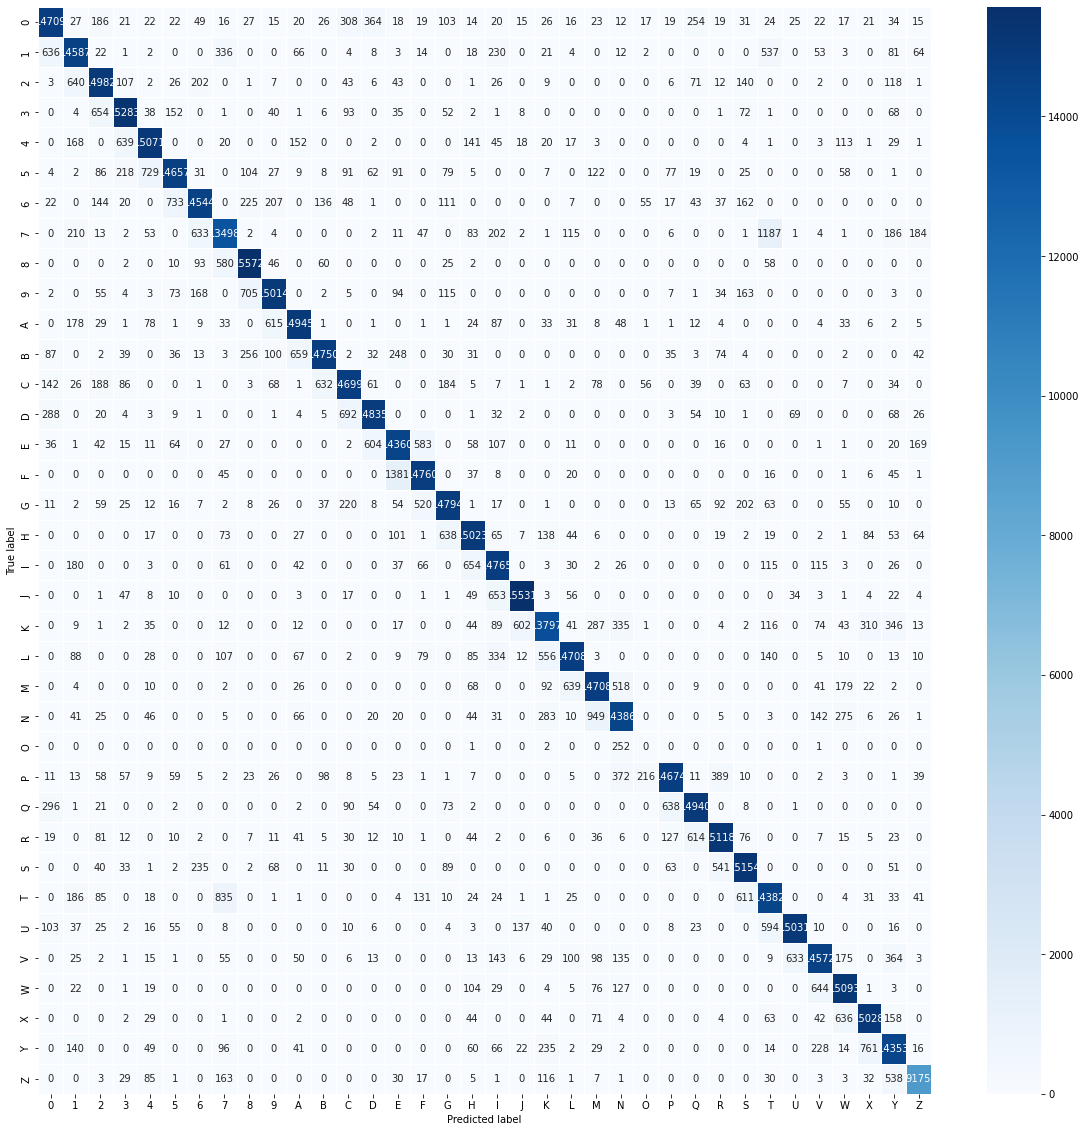

In [ ]:
cm = confusion_matrix(train_ground_truths, train_predictions)
labels_category = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# Set figure size (width, height) in inches
plt.figure(figsize=(20, 20))

sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Testing Model

##### Set to evaluation mode

In [ ]:
# Set the model to evaluation mode
resnet50.eval()

# Keep track of the validation loss and accuracy
test_loss = 0.0
test_correct = 0
test_total = 0

##### Test the model

In [ ]:
# Iterate over the validation dataset in batches
test_predictions = np.array([])
test_ground_truths = np.array([])

for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    # Forward pass
    outputs = resnet50(images)
    loss = criterion(outputs, labels)

    # Update the validation loss
    test_loss += loss.item() * labels.size(0)

    test_predictions = np.concatenate((test_predictions, predicted.cpu().numpy()))
    test_ground_truths = np.concatenate((test_ground_truths, labels.cpu().numpy()))

    # test_predictions.extend(predicted.cpu().numpy())
    # test_ground_truths.extend(labels.cpu().numpy())

    # Update the testing accuracy
    _, predicted = torch.max(outputs.data, 1)
    test_total += labels.size(0)
    test_correct += (predicted == labels).sum().item()

# Compute the average testing loss and accuracy
test_loss /= len(test_set)
test_accuracy = 100 * test_correct / test_total

# Print the testing loss and accuracy
print(f'Testing loss: {test_loss:.4f}, accuracy: {test_accuracy:.2f}%')

Testing loss: 0.1300, accuracy: 97.20%


In [ ]:
average_val = 'macro'

accuracy = accuracy_score(test_ground_truths, test_predictions)
precision = precision_score(test_ground_truths, test_predictions, average=average_val)
recall = recall_score(test_ground_truths, test_predictions, average=average_val)
f1 = f1_score(test_ground_truths, test_predictions, average=average_val)

print(f"Accuracy: {round(accuracy * 100, 2)}%")
print(f"Precision: {round(precision * 100, 2)}%")
print(f"Recall: {round(recall * 100, 2)}%")
print(f"F1 Score: {round(f1 * 100, 2)}%")

Accuracy: 66.7%
Precision: 64.89%
Recall: 64.86%
F1 Score: 64.86%


##### Calculate the confusion matrix

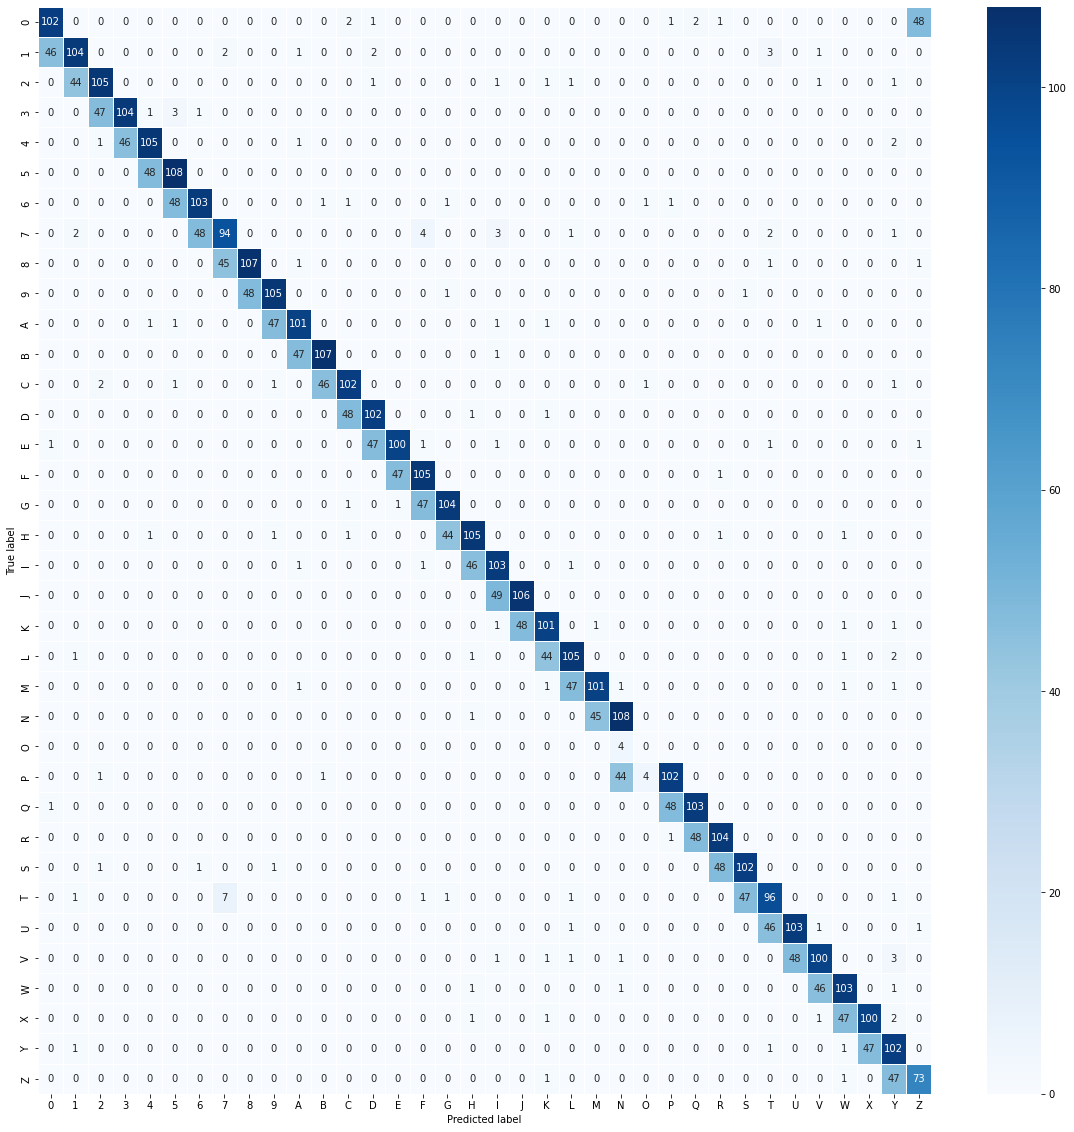

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(test_ground_truths, test_predictions)
labels_category = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N','O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

# Set figure size (width, height) in inches
plt.figure(figsize=(20, 20))

sns.heatmap(cm, annot=True, fmt='d', linewidths=.5, cmap='Blues', xticklabels= labels_category, yticklabels=labels_category)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##### Save the model

In [ ]:
# Save the state_dict model to a file
torch.save(resnet50.state_dict(), 'resnet50-letter-state-dict (new).pth')

# Save the model to a file
torch.save(resnet50, 'resnet50-letter(new).pth')